# Spectral bias

*Spectral bias* refers to the tendency of a MLP with low-dimensional inputs to learn low-frequency components of a function more easily than high-frequency details. *While this bias often improves generalization*, it can be undesirable in cases where we need the network to capture high-frequency information or overfit specific patterns (e.g., in texture compression). *One common way to reduce spectral bias is to apply positional encoding*, which expands the input into a higher-dimensional space and allows the network to model higher-frequency variations more effectively.

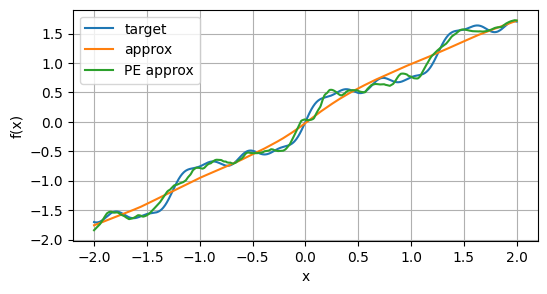

MLP MSE: 0.021475
PE MSE:  0.005707


In [4]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1337)

def function_to_approx(x):
    frequencies = torch.tensor([20.0, 10.0, 5.0, 0.5])
    y = torch.sum(1.0 / frequencies * torch.sin(torch.outer(x, frequencies)), dim=1)
    return y

pe_freq_num = 3
lr = 0.02

# define low dimensional input model
model = torch.nn.Sequential(
    torch.nn.Linear(1, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
optimizer = torch.optim.SGD(model.parameters(), lr)
loss_function = torch.nn.MSELoss()

# define positional encoding model
def build_pe_features(x : torch.Tensor):
    samples = x.unsqueeze(1)
    pe_samples = torch.cat(
        [
            torch.cat(
                [
                    torch.sin(samples * (2 ** i) * torch.pi),
                    torch.cos(samples * (2 ** i) * torch.pi),
                ],
                dim=1,
            )
            for i in range(pe_freq_num)
        ],
        dim=1,
    )
    return torch.cat([samples, pe_samples], dim=1)

pe_model = torch.nn.Sequential(
    torch.nn.Linear(pe_freq_num * 2 + 1, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
pe_optimizer = torch.optim.SGD(pe_model.parameters(), lr)
pe_loss_function = torch.nn.MSELoss()


# training loop
epoch_num = 300
samples_per_epoch = 3000
for epoch in range(epoch_num):
    x = torch.rand(samples_per_epoch) * 4 - 2
    y = function_to_approx(x).unsqueeze(1)

    # standard model training
    samples = x.unsqueeze(1)
    y_hat = model(samples)
    loss = loss_function(y, y_hat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # PE model training
    pe_samples = build_pe_features(x)
    y_hat = pe_model(pe_samples)
    loss = pe_loss_function(y, y_hat)
    pe_optimizer.zero_grad()
    loss.backward()
    pe_optimizer.step()


with torch.no_grad():
    x = torch.linspace(-2.0, 2.0, 1000)
    y = function_to_approx(x)

    x_in = x.unsqueeze(1)
    y_hat = model(x_in).squeeze(1)

    pe_x = build_pe_features(x)
    pe_y_hat = pe_model(pe_x).squeeze(1)

    plt.figure(figsize=(6, 3))
    plt.plot(x.numpy(), y.numpy(), label="target")
    plt.plot(x.numpy(), y_hat.numpy(), label="approx")
    plt.plot(x.numpy(), pe_y_hat.numpy(), label="PE approx")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True)
    plt.legend()
    plt.show()

    mse_mlp = torch.mean((y_hat - y) ** 2).item()
    mse_pe = torch.mean((pe_y_hat - y) ** 2).item()
    print(f"MLP MSE: {mse_mlp:.6f}")
    print(f"PE MSE:  {mse_pe:.6f}")
    
